# Empirical Evaluation

Loading required packages

In [1]:
library(tidyverse)
library(tidyr)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(scales)
library(grid)
library(RColorBrewer)

theme_set(theme_bw())
options(warn=-1)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine


Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor



Read generated data through fuzzing campaigns

In [2]:
data = read.table("../data/fuzzingdata.csv",sep=",",header=TRUE,comment.char = "#")
summary(data)

     subject         run            tests             empirical      
 freetype:601   Min.   : 1.00   Min.   :1.000e+02   Min.   :    0.0  
 json    :478   1st Qu.: 6.00   1st Qu.:3.200e+03   1st Qu.:   28.0  
 libcap  :617   Median :11.00   Median :1.024e+05   Median :  123.0  
 libpng  :232   Mean   :12.11   Mean   :4.080e+07   Mean   : 1192.1  
 libxml  :395   3rd Qu.:18.00   3rd Qu.:6.554e+06   3rd Qu.:  618.8  
 zlib    :489   Max.   :30.00   Max.   :1.678e+09   Max.   :70736.0  
    laplace           localgt          reset1             reset10         
 Min.   :   1.00   Min.   :    1   Min.   :1.000e+00   Min.   :        0  
 1st Qu.:  48.75   1st Qu.:  236   1st Qu.:8.600e+01   1st Qu.:       10  
 Median : 148.00   Median :  697   Median :3.423e+03   Median :      204  
 Mean   : 442.08   Mean   : 1738   Mean   :3.300e+06   Mean   :   164153  
 3rd Qu.: 433.00   3rd Qu.: 3068   3rd Qu.:8.619e+04   3rd Qu.:     7121  
 Max.   :4299.00   Max.   :13251   Max.   :4.964e+09   Max. 

For each subject, a greybox fuzzing campaign had been conducted and discovery probability estimates were recorded at each 10% increase of number of tests inputs generated. Same campaign was repeated k times (k=10). Below is how we recorded the variables in input data.

 - empirical - This is the ground truth for discovery probability. A blackbox fuzzing campaign is conducted using the seed corpus emerges through greybox fuzzing campaign. Same number of inputs are generated within the blackbox campaign. The number of inputs that would increase global species coverage within the blackbox campaign are recorded.

 - f1,f2,f3,f4 - Global number of singleton,doubleton, tripleton and quadrupleton species observe during the greybox campaign for each point.

 - v1,v2,v3,v4 - Global number of singleton,doubleton, tripleton and quadrupleton species observe during the greybox campaign without considering the species abundances for current seed.

 - localgt - Compute the Good-Turing estimate for each fuzzed seed's local distribution and aggregate it by multiplying from inclusion probability of the seed. 1 is used as local discovery probability if a seed is never fuzzed. If there are no sengletons, 1/(number of generated inputs for the seed + 2) is used.

 - laplace - Assume that for each seed we still haven't discovered the next species. Therefore computed the Laplace estimate which is 1/(number of generated inputs for the seed + 2) for local distribution and aggregate for all the seeds using inclusion probability of the seed.

 - reset1,reset10 - Resetting global species abundance counts for every added seed and every added 10th seed.
 
 Let's have a look at the estimators.

In [3]:
# Compute estimand and estimators
data$empirical          = data$empirical / data$tests
data$est_Laplace        = 1 / (data$tests + 2)
data$est_Good_Turing    = ifelse(data$f1 == 0, 1 / (data$tests + 2), data$f1 / data$tests)
data$est_ML.Laplace     = data$laplace / data$tests
data$est_ML.Good_Turing = data$localgt / data$tests
data$est_Reset.10       = data$reset10 / data$tests
data$est_Reset.1        = data$reset1 / data$tests

# Linear extrapolation
extrapolator_df = 0
train_min_tests = 100000
train_max_tests = 10000000
train_mid_tests = round((train_min_tests + train_max_tests) / 2)
for(Subject in levels(factor(data$subject))){
  subject_specific = subset(data, subject == Subject)
  for(Run in levels(factor(subject_specific$run))){
    train_data = subset(subject_specific, run == Run)
    train_data = train_data[order(train_data$tests),]
    train_data = train_data[train_data$empirical > 0,]
    train_data = train_data[c(which.min(abs(train_min_tests-train_data$tests)),
                              which.min(abs(train_mid_tests-train_data$tests)),
                              which.min(abs(train_max_tests-train_data$tests))),
                            c("tests","run","subject","empirical")]
    
    train_data$tests     = log10(train_data$tests)
    train_data$empirical = log10(train_data$empirical)
    train_data           = train_data[is.finite(train_data$empirical),]
    
    lreg = lm(empirical ~ tests, data = train_data)
    exogeneous_vars = subject_specific[subject_specific$run==Run, c("tests","run","subject")]
    exogeneous_vars = exogeneous_vars[order(exogeneous_vars$tests),]
    temp = exogeneous_vars
    temp$tests = log10(temp$tests)
    exogeneous_vars$est_Extrapolation = predict(lreg,temp)
    exogeneous_vars$est_Extrapolation = 10^(exogeneous_vars$est_Extrapolation)
    if(extrapolator_df == 0){
        extrapolator_df = exogeneous_vars
    } else{
        extrapolator_df = rbind(extrapolator_df, exogeneous_vars)
    }
  }
}

data = merge(x=data, y=extrapolator_df, by=c("tests","run","subject"))

head(data)
summary(subset(data, subject=="libcap"))

tests,run,subject,empirical,laplace,localgt,reset1,reset10,b1,f1,...,v2,v3,v4,est_Laplace,est_Good_Turing,est_ML.Laplace,est_ML.Good_Turing,est_Reset.10,est_Reset.1,est_Extrapolation
100,1,freetype,0.24,44,4625,1000,2307,375,98,...,1620,40,6,0.009803922,0.980000000,0.44,46.25,23.07,10.00,0.5024575
100,1,json,0.00,2,55,1,0,0,0,...,0,0,0,0.009803922,0.009803922,0.02,0.55,0.00,0.01,3285.9101580
100,1,libcap,0.00,2,6,14,0,0,1,...,0,1,0,0.009803922,0.010000000,0.02,0.06,0.00,0.14,0.1341160
100,1,libpng,0.33,19,445,363,205,33,33,...,5,1,0,0.009803922,0.330000000,0.19,4.45,2.05,3.63,5.7202686
100,1,libxml,0.00,11,450,300,117,0,7,...,3,0,0,0.009803922,0.070000000,0.11,4.50,1.17,3.00,5.6843708
100,1,zlib,0.00,1,1,1,0,0,0,...,0,0,0,0.009803922,0.009803922,0.01,0.01,0.00,0.01,1.4688184


     tests                run            subject      empirical        
 Min.   :      100   Min.   : 1.00   freetype:  0   Min.   :0.000e+00  
 1st Qu.:     3200   1st Qu.: 7.00   json    :  0   1st Qu.:1.440e-06  
 Median :   102400   Median :14.00   libcap  :617   Median :1.032e-04  
 Mean   : 28827255   Mean   :14.67   libpng  :  0   Mean   :2.427e-03  
 3rd Qu.:  3276800   3rd Qu.:22.00   libxml  :  0   3rd Qu.:6.250e-04  
 Max.   :838860800   Max.   :30.00   zlib    :  0   Max.   :1.150e-01  
    laplace          localgt           reset1           reset10      
 Min.   :   1.0   Min.   :   1.0   Min.   :      1   Min.   :     0  
 1st Qu.:   2.0   1st Qu.:   4.0   1st Qu.:      9   1st Qu.:     0  
 Median :  46.0   Median : 121.0   Median :    252   Median :    13  
 Mean   : 147.8   Mean   : 215.7   Mean   :  63569   Mean   :  1987  
 3rd Qu.: 201.0   3rd Qu.: 356.0   3rd Qu.:   8681   3rd Qu.:   136  
 Max.   :1173.0   Max.   :1440.0   Max.   :5501788   Max.   :215756  
      

In [4]:
# Compute Average
data_avg = data %>%
  group_by(tests,subject) %>%
  summarise_at(vars(-run), funs(mean(., na.rm=TRUE)))

# Pivot estimators into factors under values
data = data %>% 
  pivot_longer(
    cols = starts_with("est"), 
    names_to  = "estimator", 
    values_to = "estimate", 
    names_prefix = "est_")

data_avg = data_avg %>% 
  pivot_longer(
    cols = starts_with("est"), 
    names_to  = "estimator", 
    values_to = "estimate", 
    names_prefix = "est_")
names(data_avg)[names(data_avg)=="empirical"] <- "avg_empirical"
names(data_avg)[names(data_avg)=="estimate"]  <- "avg_estimate"
names(data_avg)[names(data_avg)=="b1"]  <- "avg_b1"

data = merge(x=data,
             y=data_avg[,c("tests","subject","avg_empirical","estimator","avg_estimate","avg_b1")],
             by=c("tests","subject","estimator"))

summary(data)

     tests               subject      estimator              run       
 Min.   :1.000e+02   freetype:4207   Length:19684       Min.   : 1.00  
 1st Qu.:3.200e+03   json    :3346   Class :character   1st Qu.: 6.00  
 Median :1.024e+05   libcap  :4319   Mode  :character   Median :11.00  
 Mean   :4.080e+07   libpng  :1624                      Mean   :12.11  
 3rd Qu.:6.554e+06   libxml  :2765                      3rd Qu.:18.00  
 Max.   :1.678e+09   zlib    :3423                      Max.   :30.00  
   empirical            laplace           localgt          reset1         
 Min.   :0.0000000   Min.   :   1.00   Min.   :    1   Min.   :1.000e+00  
 1st Qu.:0.0000131   1st Qu.:  48.75   1st Qu.:  236   1st Qu.:8.600e+01  
 Median :0.0007734   Median : 148.00   Median :  697   Median :3.423e+03  
 Mean   :0.0282529   Mean   : 442.08   Mean   : 1738   Mean   :3.300e+06  
 3rd Qu.:0.0215869   3rd Qu.: 433.00   3rd Qu.: 3068   3rd Qu.:8.619e+04  
 Max.   :0.6000000   Max.   :4299.00   Max.   

## Plot Mean Estimates

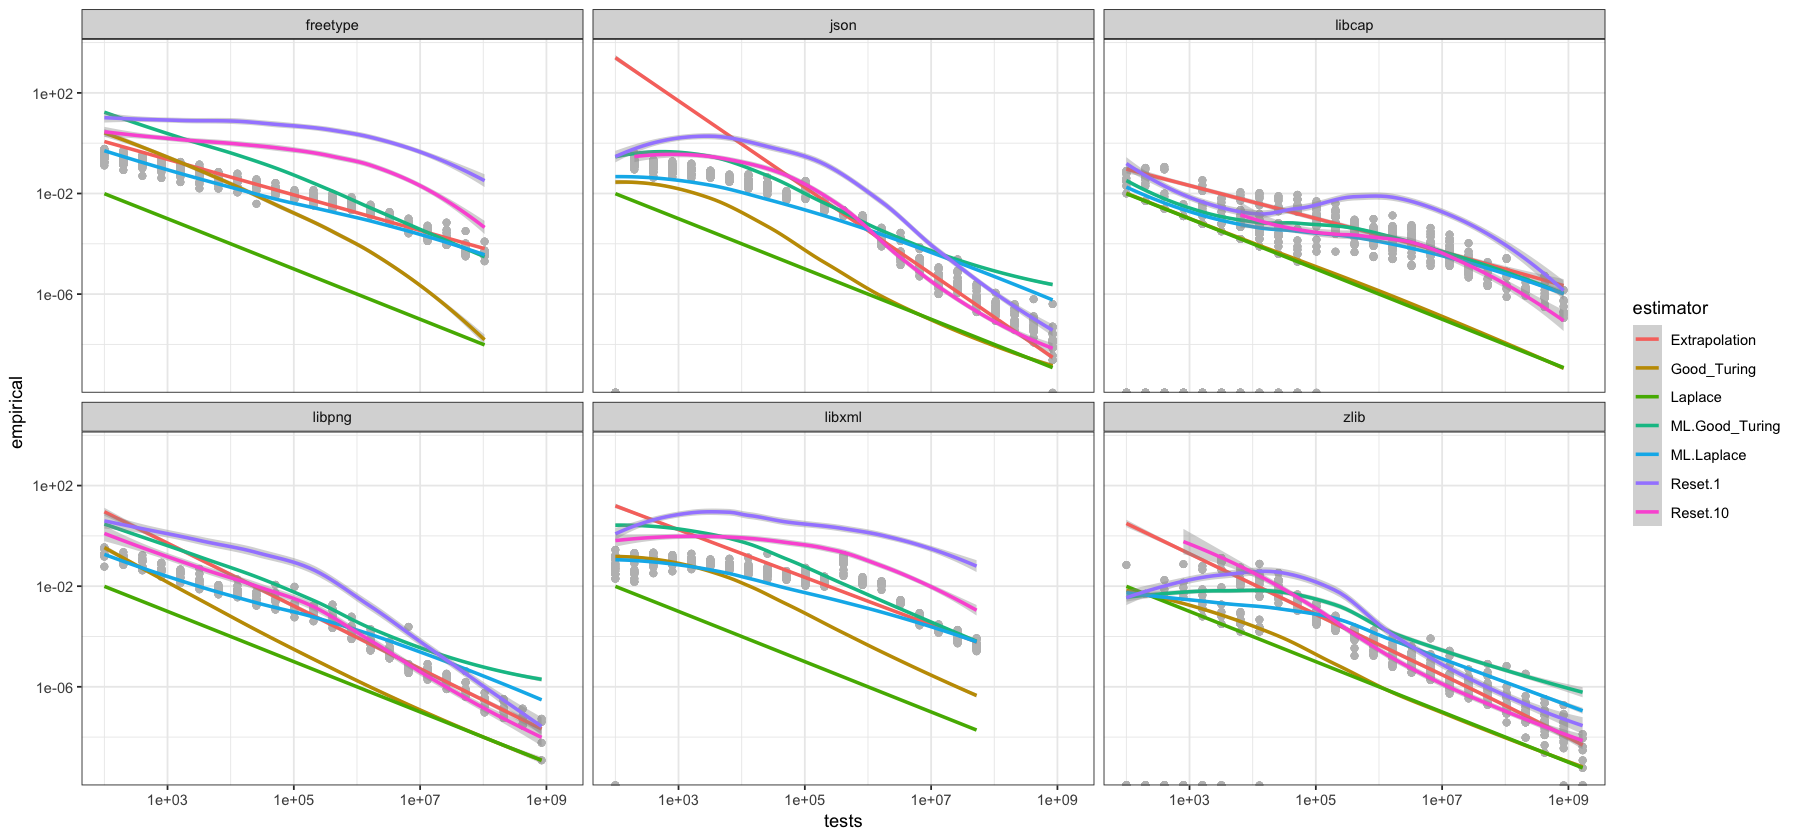

In [5]:
options(repr.plot.width = 15, repr.plot.height = 7)
ggplot(data) + 
  geom_point(aes(tests,empirical), color = "gray") + 
  #geom_point(aes(tests,avg_empirical)) + 
  geom_smooth(aes(tests,estimate,color=estimator), method="loess", formula="y ~ x") + 
  scale_y_log10() +
  scale_x_log10() + 
  facet_wrap(~subject)

## Assessing Bias

As the first step, the average empirical values are computed for each #tests and subject combination. The difference between the log(estimate) and log(average empirical value) is evaluated and these differences are averaged out over all runs to compute the corresponding bias for a given #tests, subject combination.

These bias measures are plotted against number of tests generated.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


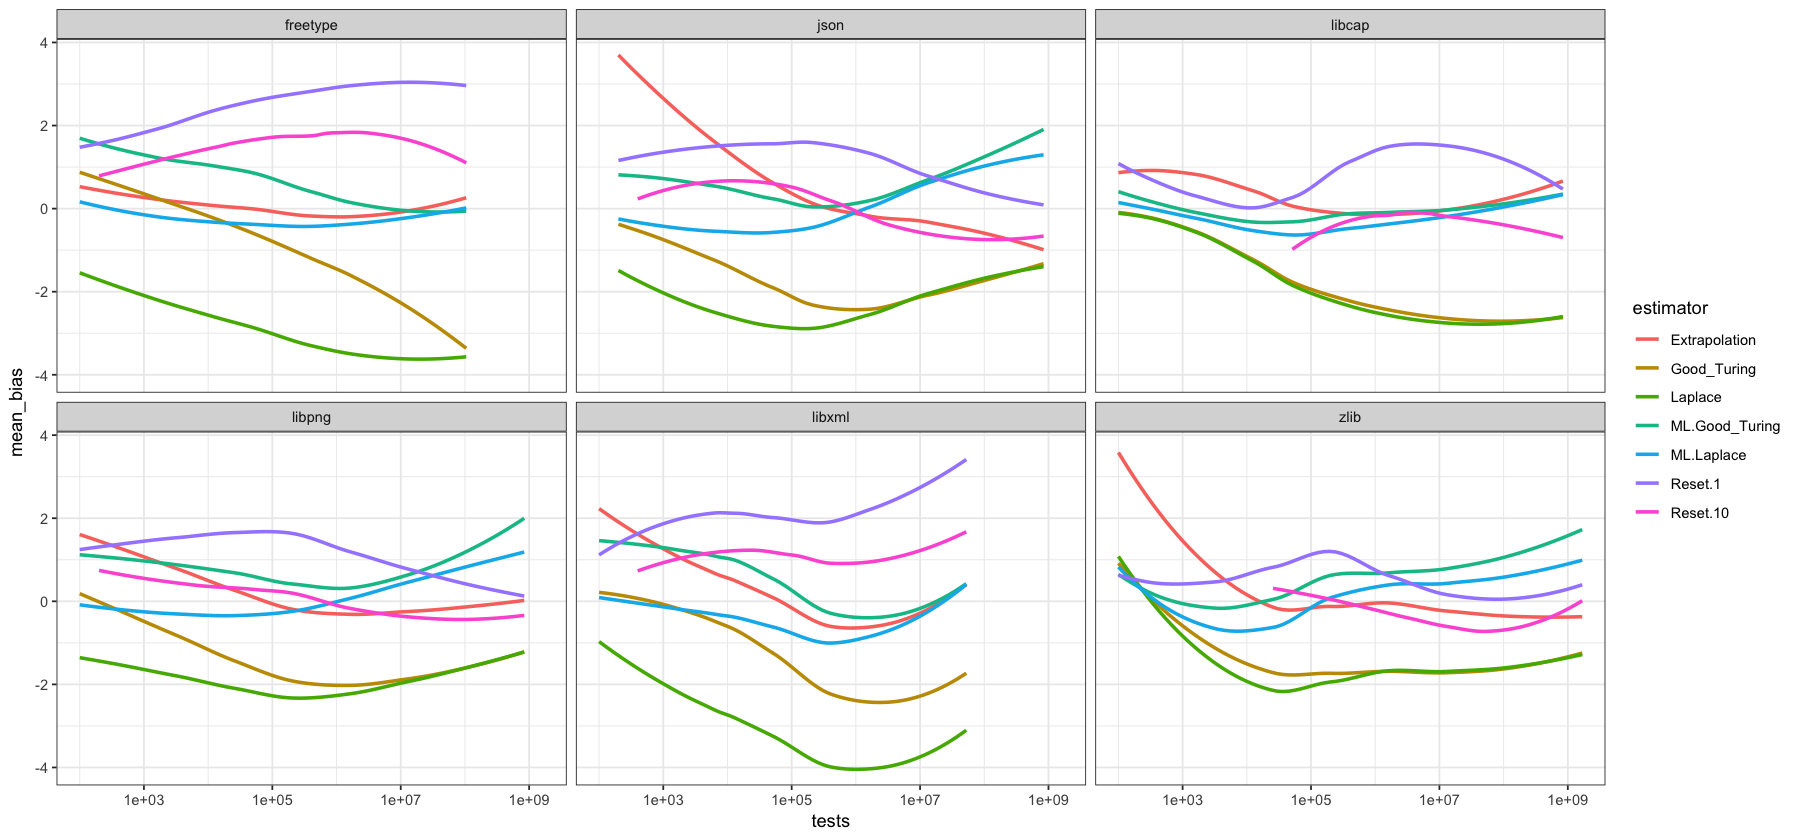

In [6]:
# Individual bias
data$bias = log10(data$estimate) - log10(data$avg_empirical)

# Mean bias
mean_bias_df = data %>%
  group_by(tests,subject,estimator) %>%
  summarise_at(vars(-run), funs(mean(., na.rm=TRUE)))
names(mean_bias_df)[names(mean_bias_df)=="bias"] <- "mean_bias"

# Merge into data
data = merge(x=data,
             y=mean_bias_df[,c("tests","subject","estimator","mean_bias")],
             by=c("tests","subject","estimator"))

ggplot(data) +
  geom_smooth(aes(tests, mean_bias, color=estimator),se=F) + 
  facet_wrap(~subject) +
  scale_x_log10()

## Assessing Variance

The variance of the estimates are computed and it reflects the imprecision of the estimator. If the variance is lower in magnitude compared to another estimator, we consider it to have a higher precision.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


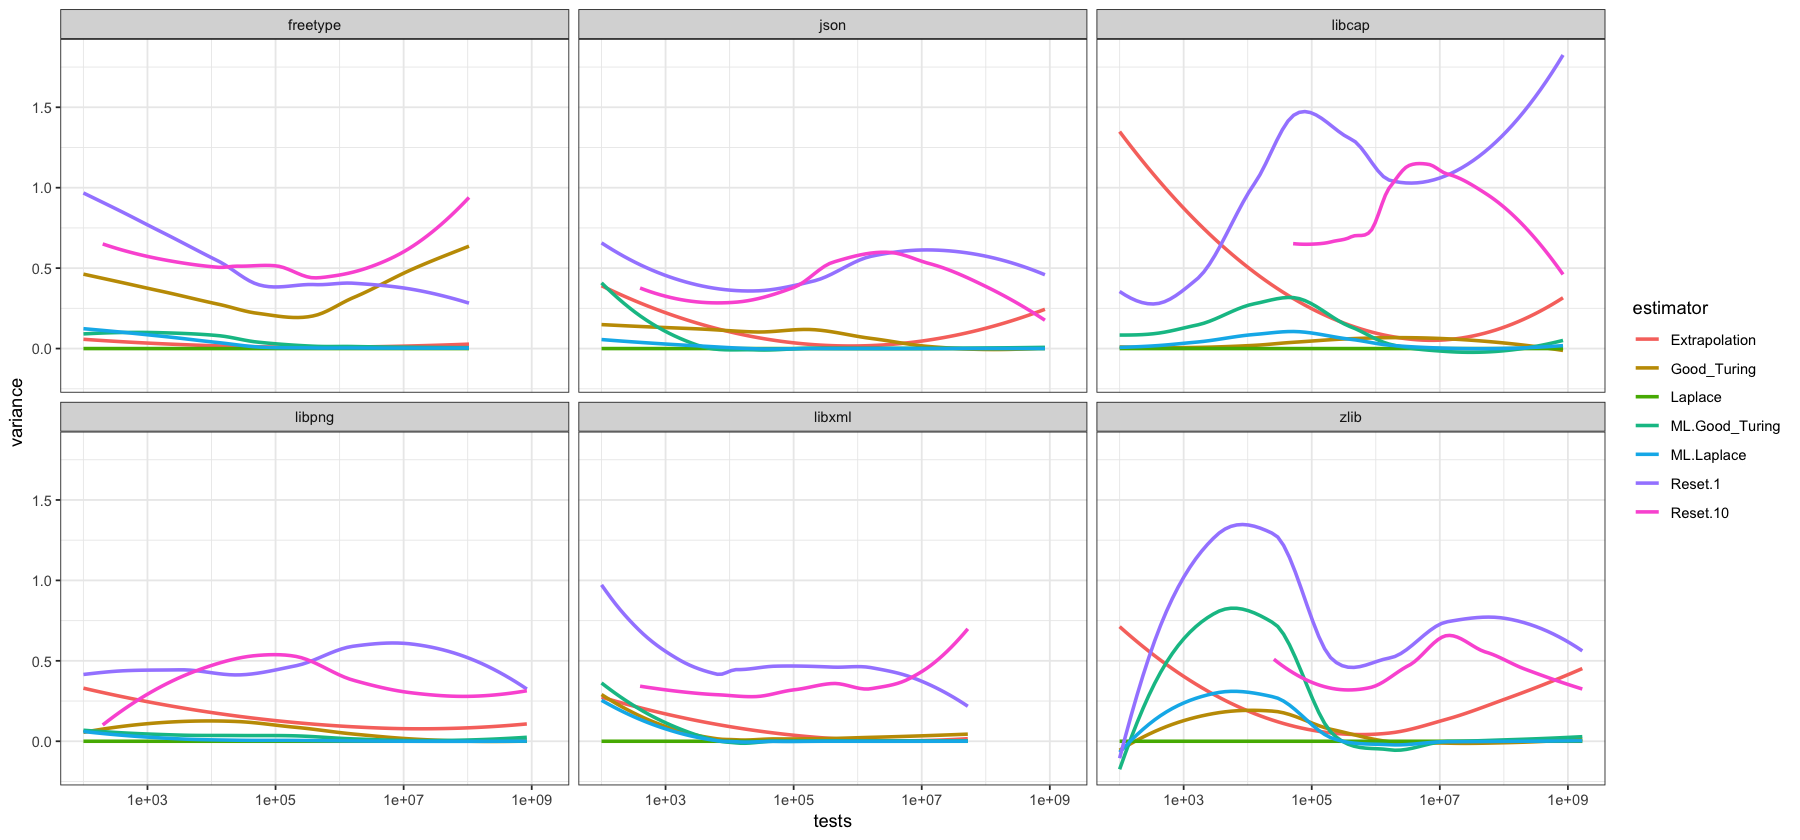

In [7]:
# Logarithm of individual estimate
data$log_estimate = log10(data$estimate)

# Variance of the logarithm of the estimates
variance_df = data %>%
    group_by(tests, subject, estimator) %>%
    summarise_at(vars(-run), funs(var(., na.rm=TRUE)))
names(variance_df)[names(variance_df)=="log_estimate"] <- "variance"

# Merge into data
data = merge(x=data,
             y=variance_df[,c("tests","subject","estimator","variance")],
             by=c("tests","subject","estimator"))

ggplot(data) +
  geom_smooth(aes(tests, variance, color=estimator),se=F) + 
  facet_wrap(~subject) +
  scale_x_log10()

## Generating Plots

### RQ.1 Traditional Estimators

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


pdf 
  2

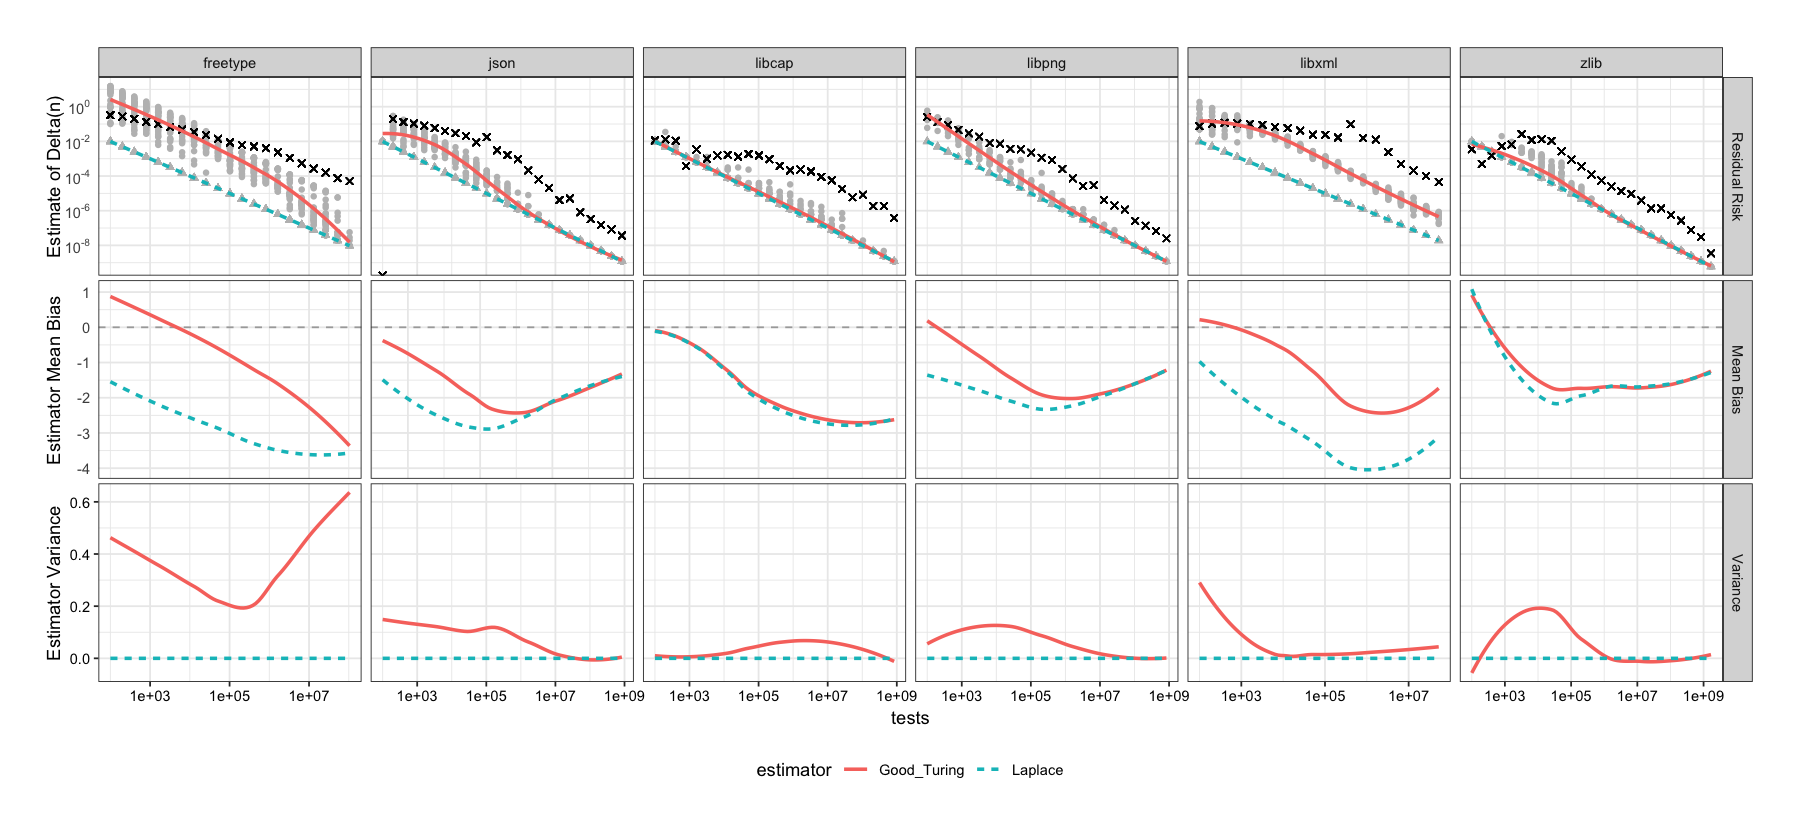

In [8]:
toplot = subset(data, estimator %in% c("Laplace","Good_Turing"))

toplot$title = "Residual Risk"
p1 = ggplot(toplot) + 
  #geom_point(aes(tests,empirical), color = "gray") + 
  geom_point(aes(tests,estimate, shape=estimator), color="gray") +
  geom_point(aes(tests,avg_empirical),shape=4) + 
  geom_smooth(aes(tests,estimate,linetype=estimator,color=estimator), method="loess", formula="y ~ x", se=FALSE) +
  scale_y_log10("Estimate of Delta(n)",
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
  scale_x_log10() +
  scale_fill_brewer(palette = "Dark") +
  expand_limits(x = 100, y = 1) +
  facet_grid(title~subject, scale="free") +
  theme(#axis.text.x = element_text(colour="black"), axis.text.y = element_text(colour="black"), 
        legend.position = "none",
        axis.text.x = element_blank(), axis.title.x = element_blank(), axis.ticks=element_blank(),
        plot.margin = unit(c(1,1,0,1), "cm"))

toplot$title = "Mean Bias"
p2 = ggplot(toplot) + 
  geom_hline(yintercept=0, linetype="dashed", color = "darkgrey") +
  geom_smooth(aes(tests, mean_bias, linetype=estimator,color=estimator), se=FALSE) +
  facet_wrap(~subject) +
  scale_x_log10() +
  scale_fill_brewer(palette = "Dark") +
  ylab("Estimator Mean Bias") +
  facet_grid(title~subject, scale="free_x") +
  theme(legend.position = "none",
        axis.text.x = element_blank(), axis.title.x = element_blank(), axis.ticks=element_blank(),
        strip.background.x = element_blank(), strip.text.x = element_blank(),
        plot.margin = unit(c(0,1,0,1), "cm"))

toplot$title = "Variance"
p3 = ggplot(toplot) + 
  geom_smooth(aes(tests, variance, linetype=estimator, color=estimator), se=FALSE) + 
  facet_wrap(~subject) +
  scale_x_log10() +
  scale_fill_brewer(palette = "Dark") +
  ylab("Estimator Variance") +
  facet_grid(title~subject, scale="free_x") +
  theme(axis.text.x = element_text(colour="black"), axis.text.y = element_text(colour="black"),
        strip.background.x = element_blank(), strip.text.x = element_blank(),
        plot.margin = unit(c(0,1,1,1), "cm"),
        legend.position = "bottom")

grid.newpage()
grid.draw(rbind(ggplotGrob(p1), ggplotGrob(p2), ggplotGrob(p3), size = "last"))


pdf("../outputs/RQ1.pdf", width = 14)
grid.newpage()
grid.draw(rbind(ggplotGrob(p1), ggplotGrob(p2), ggplotGrob(p3), size = "last"))
dev.off()

### RQ.2 Our Estimators

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


pdf 
  2

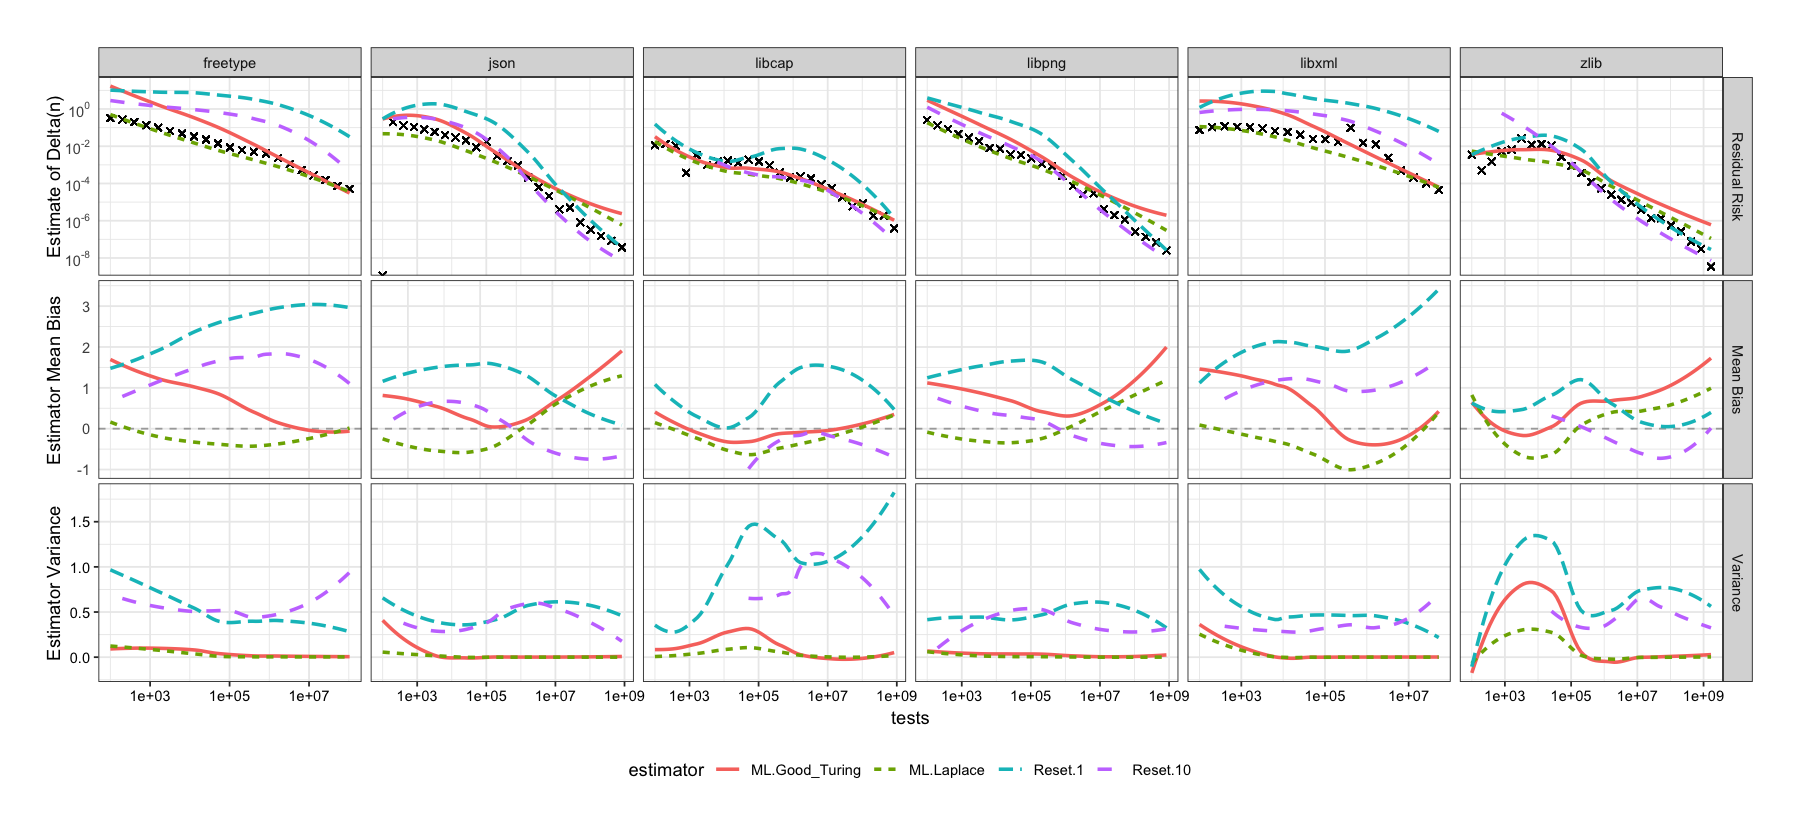

In [9]:
toplot = subset(data, estimator %in% c("ML.Laplace","ML.Good_Turing","Reset.1","Reset.10"))

toplot$title = "Residual Risk"
p1 = ggplot(toplot) + 
  #geom_point(aes(tests,empirical), color = "gray") + 
  #geom_point(aes(tests,estimate, shape=estimator), color="gray") +
  geom_point(aes(tests,avg_empirical),shape=4) + 
  geom_smooth(aes(tests,estimate,linetype=estimator,colour=estimator), method="loess", formula="y ~ x",se=F) +
  scale_y_log10("Estimate of Delta(n)",
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
  scale_x_log10() + 
  scale_fill_brewer(palette = "Dark") +
  expand_limits(x = 100, y = 1) +
  facet_grid(title~subject, scale="free") +
  theme(#axis.text.x = element_text(colour="black"), axis.text.y = element_text(colour="black"), 
        legend.position = "none",
        axis.text.x = element_blank(), axis.title.x = element_blank(), axis.ticks=element_blank(),
        plot.margin = unit(c(1,1,0,1), "cm"))

toplot$title = "Mean Bias"
p2 = ggplot(toplot) + 
  geom_hline(yintercept=0, linetype="dashed", color = "darkgrey") +
  geom_smooth(aes(tests, mean_bias, linetype=estimator,colour=estimator),se=F) +
  facet_wrap(~subject) +
  scale_x_log10() +
  scale_fill_brewer(palette = "Dark") +
  ylab("Estimator Mean Bias") +
  facet_grid(title~subject, scale="free_x") +
  theme(legend.position = "none",
        axis.text.x = element_blank(), axis.title.x = element_blank(), axis.ticks=element_blank(),
        strip.background.x = element_blank(), strip.text.x = element_blank(),
        plot.margin = unit(c(0,1,0,1), "cm"))

toplot$title = "Variance"
p3 = ggplot(toplot) + 
  geom_smooth(aes(tests, variance, linetype=estimator,colour=estimator),se=F) + 
  facet_wrap(~subject) +
  scale_x_log10() +
  scale_fill_brewer(palette = "Dark") +
  ylab("Estimator Variance") +
  facet_grid(title~subject, scale="free_x") +
  theme(axis.text.x = element_text(colour="black"), axis.text.y = element_text(colour="black"),
        strip.background.x = element_blank(), strip.text.x = element_blank(),
        plot.margin = unit(c(0,1,1,1), "cm"),
        legend.position = "bottom")

grid.newpage()
grid.draw(rbind(ggplotGrob(p1), ggplotGrob(p2), ggplotGrob(p3), size = "last"))


pdf("../outputs/RQ2.pdf", width = 14)
grid.newpage()
grid.draw(rbind(ggplotGrob(p1), ggplotGrob(p2), ggplotGrob(p3), size = "last"))
dev.off()

### RQ.3 Extrapolation
Assessing Goodness-Of-Fit of Linear Regression

In [10]:
agg_R = 0
R2data = data.frame("subject"=character(),"R2"=character())
for (s in levels(factor(data$subject))) {
  specific = subset(data, subject == s & tests > 1000)
  R2 = summary(lm(log(specific$avg_empirical) ~ log(specific$tests)))$r.squared
  R2data = rbind(R2data, data.frame(subject = s, R2=paste0("R² = ",formatC(100 * R2, format = "f", digits = 2), "%")))
  print(paste(s, ":", R2))
  agg_R = agg_R + R2
}
print(paste("Average R-squared =",agg_R / length(levels(factor(data$subject)))))

[1] "freetype : 0.978596220611096"
[1] "json : 0.968261747309909"
[1] "libcap : 0.870062705029834"
[1] "libpng : 0.971233905426022"
[1] "libxml : 0.796977127441143"
[1] "zlib : 0.97549307891794"
[1] "Average R-squared = 0.926770797455991"


Saving 3.5 x 6 in image


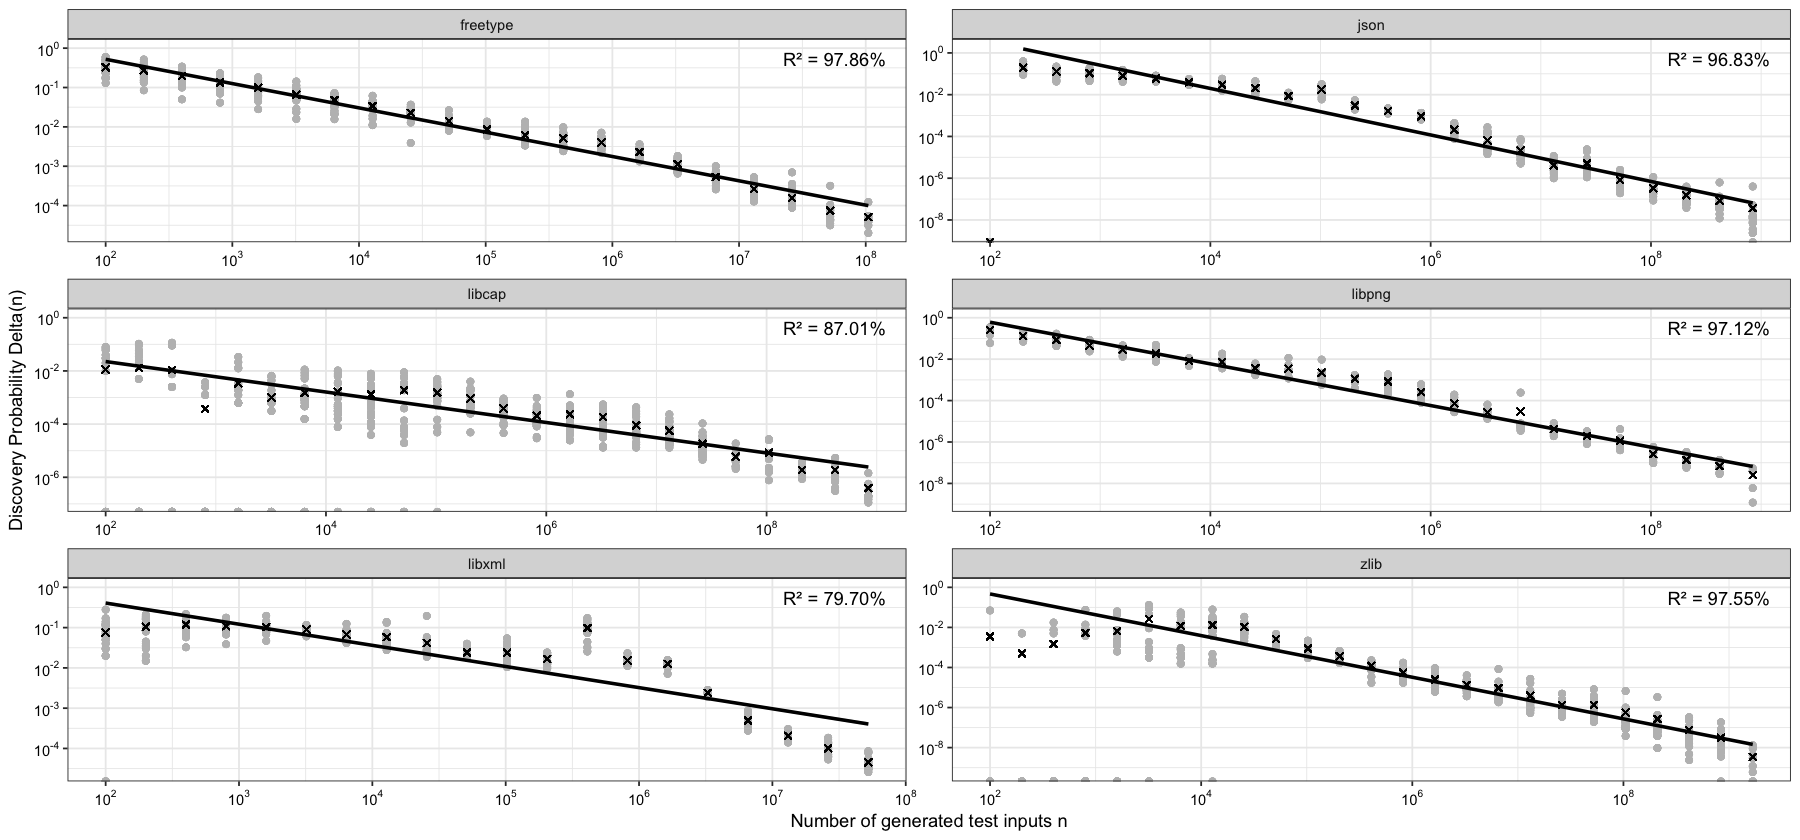

In [11]:
ggplot(data) + 
  geom_point(aes(tests,empirical), color = "gray") + 
  geom_point(aes(tests,avg_empirical),shape=4) + 
  geom_smooth(aes(tests,empirical), method="lm", formula="y ~ x", color = "black", se=T) +
  geom_text(data = R2data, aes(x = Inf, y = Inf, label = R2), hjust=1.2, vjust=2) +
  scale_y_log10("Discovery Probability Delta(n)",
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
  scale_x_log10("Number of generated test inputs n",
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
  expand_limits(x = 100, y = 1) +
  facet_wrap(~subject, scale="free", ncol=2) +
  theme(axis.text.x = element_text(colour="black"), axis.text.y = element_text(colour="black"))
ggsave("../outputs/RQ3.pdf",scale=0.5,height=12)

## Discovery Probability in Blackbox Campaigns

Plot the GT estimates for the blackbox campaigns started at the current corpus C_n

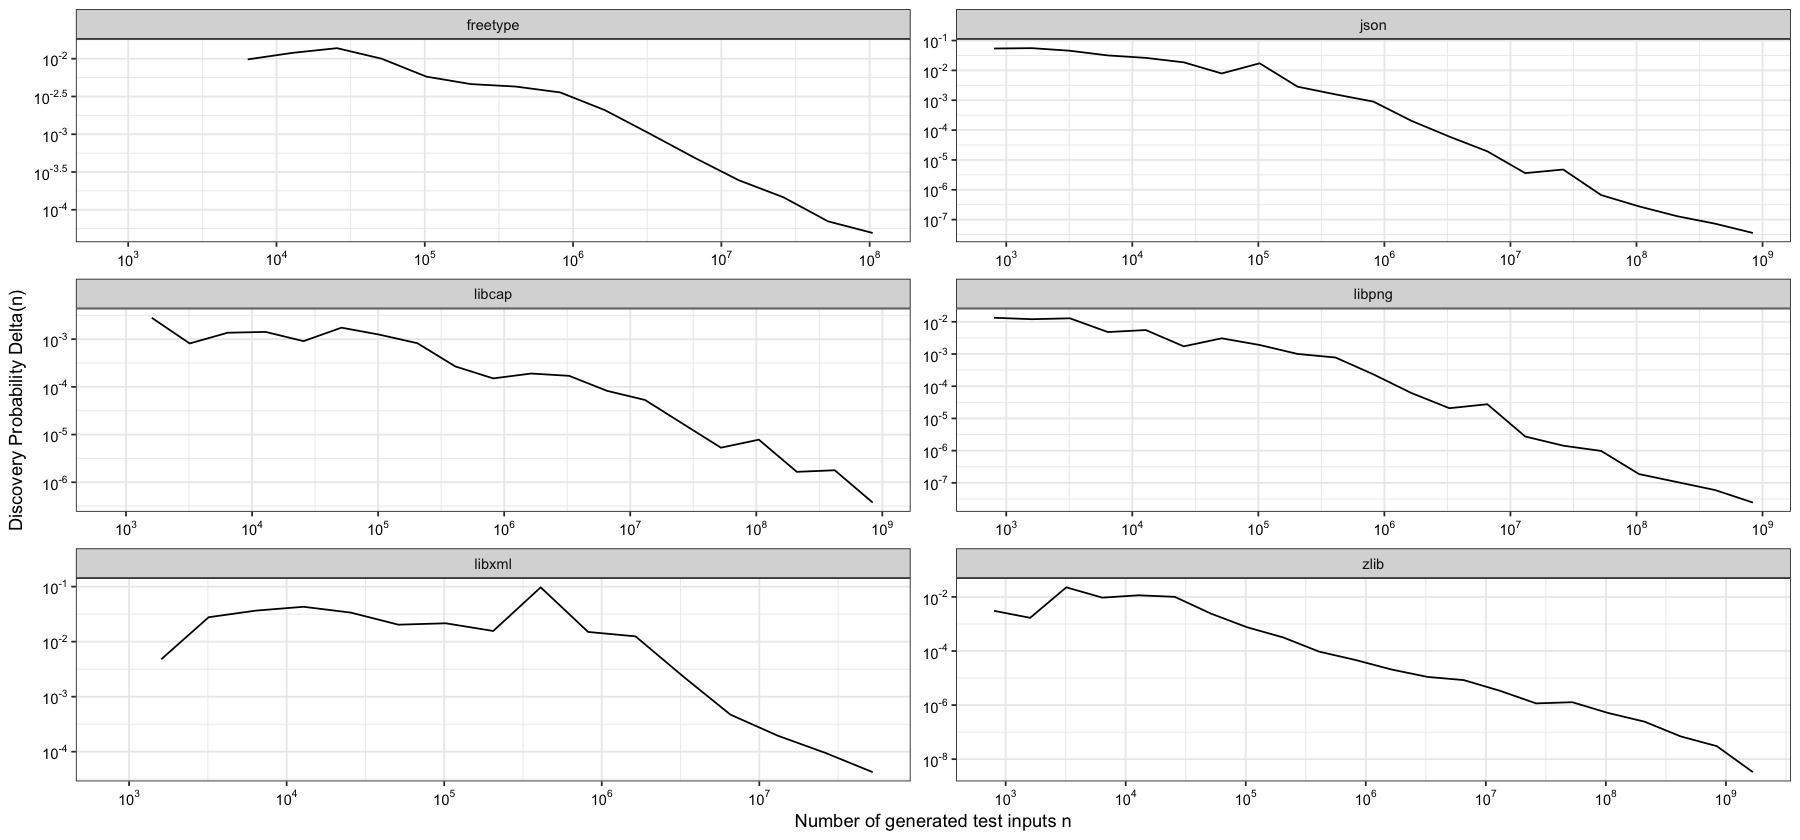

In [12]:
new_data = data.frame("subject"=character(), "tests" = integer(), "value" = numeric())
for (Subject in levels(factor(data$subject))) {
  subject_specific = subset(data, subject == Subject & tests > 400)
  for (Tests in levels(factor(sort(subject_specific$tests)))) {
    tests_specific = head(subset(subject_specific, tests == as.integer(Tests)), n=1) # average values in the first row
    new_data = rbind(new_data, data.frame(subject=Subject, tests=as.integer(Tests), value=tests_specific$avg_empirical - (tests_specific$avg_b1 / tests_specific$tests)))
  }
}

ggplot(data) + 
  #geom_point(aes(tests,empirical), color = "gray") + 
  #geom_point(aes(tests,avg_empirical),shape=4) + 
  geom_line(data=new_data, aes(tests,value)) +
  scale_y_log10("Discovery Probability Delta(n)",
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
  scale_x_log10("Number of generated test inputs n",
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
  #expand_limits(x = 100, y = 1) +
  facet_wrap(~subject, scale="free", ncol=2) +
  theme(axis.text.x = element_text(colour="black"), axis.text.y = element_text(colour="black"))